# Time Series Models

Time series analysis is one of the more important applications in data science, given the importance placed on forecasting and prediction. At the same time, it presents a new set of challenges to analysts:

* many of the typical statistical assumptions do not apply
* time series data are typically sparser than static data
* model validation is more difficult

At its simplest, time series data are sequences of observations, where each observation can be related to previous observations. 

> *Time series* is a series of data points indexed (or listed or graphed) in time order.

This implies a lack of independence among the observations; specifically, the order of the observations is important, and must be taken into account for any analysis.


In [62]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
from scipy.linalg import cholesky
from sklearn.preprocessing import StandardScaler
import warnings

sampler_kwargs = {"cores": 4, "chains": 4, "draws": 250,
                  "return_inferencedata": True}

warnings.simplefilter('ignore')

RANDOM_SEED = 20090425

## Simple Statistical Models

Often we don't need a full mechanistic model, but rather seek to build simple models which capture the time series behaviour of the data. These may be used to provide an adequate basis for forecasting. 

### Example: Pancreatitis prevalence

Pancreatitis is the inflammation of the pancreas, most commonly caused by alcohol or gallstones. A systematic review in 2010 yielded several age-specific point estimates of incidence for the disease accross Europe. Here are the data for Finland.

In [2]:
data = pd.read_csv(pm.get_data('pancreatitis.csv'))
data = data[data.area=='FIN']

age = data['age'] = np.array(data.age_start + data.age_end) / 2
rate = data.value = data.value * 1000

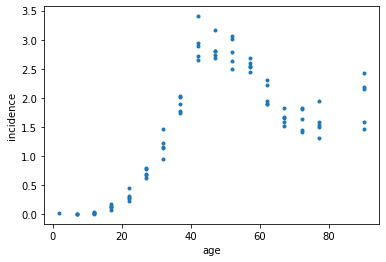

In [3]:
plt.plot(data.age, data.value, '.')
plt.xlabel('age')
plt.ylabel('incidence');

We will try to model this series (which is not really a time series) as a Gaussian random walk. A random walk is a sequence of variables whereby the next value in the sequence is the current value plus a random value, drawn independently from some distribution $P$:

$$y_t = y_{t+1} + \epsilon_{t+1} $$

$$\epsilon_t \sim P$$

In the case of a Gaussian random walk, the distribution $P$ is a normal distribution.

The vector of latent incidence is given a prior distribution by `GaussianRandomWalk`. As its name suggests GaussianRandomWalk is a vector valued distribution where the values of the vector form a random normal walk of length n, as specified by the `shape` argument. The scale of the innovations of the random walk, `sigma`, is specified in terms of the standard deviation of the normally distributed innovations and can be a scalar or vector.

Here is the log-likelihood of `GaussianRandomWalk` in PyMC3:

```python
def logp(self, x):

        x_im1 = x[:-1]
        x_i = x[1:]

        innov_like = Normal.dist(mu=x_im1 + self.mu, sigma=self.sigma).logp(x_i)
        return self.init.logp(x[0]) + tt.sum(innov_like)
```

In [4]:
nknots = 9
knots = np.linspace(data.age.min(), data.age.max(), nknots)

with pm.Model() as ghme_model:
    
    coeff_sd = pm.HalfCauchy('coeff_sd', 5)
    y = pm.GaussianRandomWalk('y', sigma=coeff_sd, shape=nknots)

In order to generalize from the knots of the model to other points across the range of the data--most notably, to the observed values--we require an interpolation function

In [5]:
def interpolate(x0, y0, x):
    x = np.array(x)

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

In [6]:
with ghme_model:
    p = interpolate(knots, y, age)

All that remains is to specify the likelihood, which in this case can be specified as Gaussian.

In [7]:
with ghme_model:
    sd = pm.HalfCauchy('sd', 5)
    vals = pm.Normal('vals', p, sigma=sd, observed=rate.values)

In [8]:
with ghme_model:
    trace = pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, y, coeff_sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [20]:
trace.posterior["y"].to_dataframe().unstack("y_dim_0")

y                                                    \
y_dim_0            0         1         2         3         4         5   
chain draw                                                               
0     0     0.036148  0.281466  0.184650  1.615704  3.015981  2.615888   
      1     0.330345 -0.057576  0.442640  1.510982  3.082823  2.503162   
      2    -0.283214  0.085084  0.311132  1.804830  3.194710  2.449458   
      3    -0.198382  0.157020  0.156524  1.717903  3.107164  2.455163   
      4    -0.275231  0.187307  0.324778  1.620376  3.094071  2.472608   
...              ...       ...       ...       ...       ...       ...   
3     995   0.176919  0.046032  0.522208  1.630090  3.187063  2.562128   
      996   0.073778  0.110051  0.464380  1.661421  3.201131  2.603926   
      997   0.127926  0.031816  0.338735  1.626047  3.177579  2.553979   
      998  -0.120420 -0.014713  0.433195  1.627230  3.064200  2.572711   
      999   0.170369  0.096380  0.280787  1.630516  3.118744  2.555206   

                                          
y_dim_0            6         7         8  
chain draw                                
0     0     1.576650  1.565277  1.947181  
      1     1.614694  1.619312  1.879254  
      2     1.617149  1.479648  1.999328  
      3     1.639108  1.516055  1.969019  
      4     1.576570  1.809084  2.117506  
...              ...       ...       ...  
3     995   1.575791  1.631102  1.897729  
      996   1.467610  1.520612  1.859012  
      997   1.650297  1.592336  2.008349  
      998   1.555248  1.539247  2.004765  
      999   1.592811  1.566270  2.017439  

[4000 rows x 9 columns]

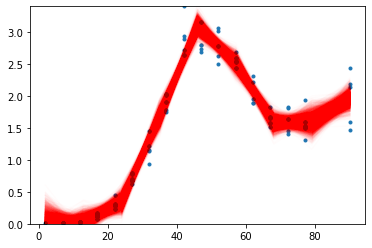

In [22]:
plt.plot(data.age, data.value, '.')
plt.plot(knots, trace.posterior["y"].to_dataframe().unstack("y_dim_0").values.T, 
         color='r', alpha=.01)

plt.ylim(0, rate.max());

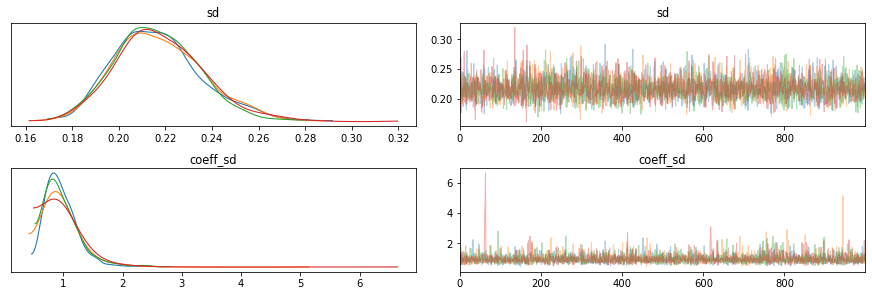

In [23]:
az.plot_trace(trace, var_names=['sd', 'coeff_sd']);

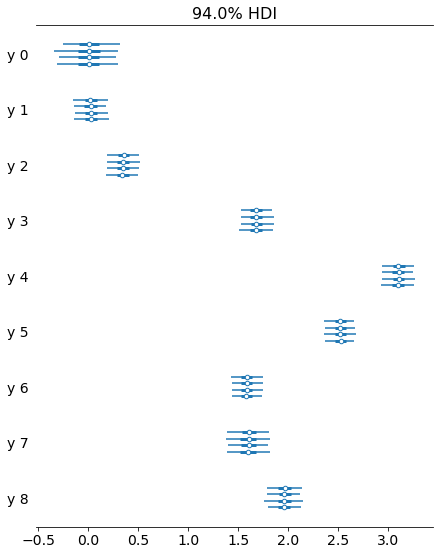

In [24]:
az.plot_forest(trace, var_names=['y']);

### Multivariate Gaussian Random Walk

The pancreatitis dataset consists of a set of countries, for which we may wish to jointly estimate disease incidence.

In [25]:
data = pd.read_csv(pm.get_data('pancreatitis.csv'))
countries = ['CYP', 'DNK', 'ESP', 'FIN', 'GBR', 'ISL']
data = data[data.area.isin(countries)]

age = data['age'] = np.array(data.age_start + data.age_end) / 2
rate = data.value = data.value * 1000
group, countries = pd.factorize(data.area)

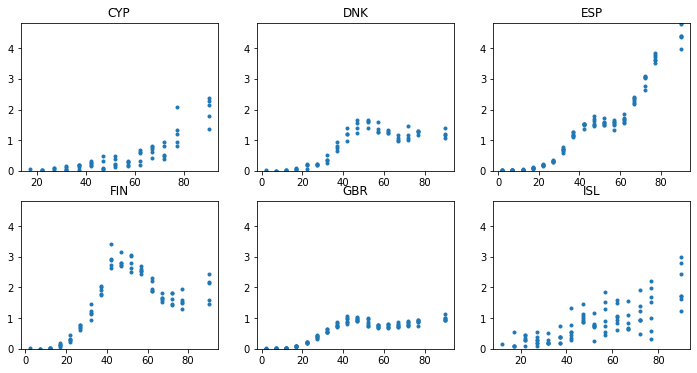

In [26]:
ncountries = len(countries)
plt.figure(figsize=(12,6))

for i, country in enumerate(countries):
    plt.subplot(2, 3, i + 1)
    plt.title(country)
    d = data[data.area == country]
    plt.plot(d.age, d.value, '.')

    plt.ylim(0, rate.max())

To jointly model sets of (correlated) time series, we can use the `MvGaussianRandomWalk` class, which models a set of time series with Gaussian innovations. This requires generalizing the `sigma` scale parameter for the random walk to a covariance matrix in the multivariate case.

While the [inverse-Wishart distribution](https://en.wikipedia.org/wiki/Inverse-Wishart_distribution) is the conjugate prior for the covariance matrix of a multivariate normal distribution, it is [not very well-suited](https://github.com/pymc-devs/pymc3/issues/538#issuecomment-94153586) to modern Bayesian computational methods.  For this reason, the [LKJ prior](http://www.sciencedirect.com/science/article/pii/S0047259X09000876) is recommended when modeling the covariance matrix of a multivariate normal distribution.

The sampling distribution for the multivariate normal model is $\mathbf{x} \sim N(\mu, \Sigma)$, where $\Sigma$ is the covariance matrix of the sampling distribution, with $\Sigma_{ij} = \textrm{Cov}(x_i, x_j)$.  The density of this distribution is

$$f(\mathbf{x}\ |\ \mu, \Sigma^{-1}) = (2 \pi)^{-\frac{k}{2}} |\Sigma|^{-\frac{1}{2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)\right).$$

The LKJ distribution provides a prior on the correlation matrix, $\mathbf{C} = \textrm{Corr}(x_i, x_j)$, which, combined with priors on the standard deviations of each component, [induces](http://www3.stat.sinica.edu.tw/statistica/oldpdf/A10n416.pdf) a prior on the covariance matrix, $\Sigma$.  Since inverting $\Sigma$ is numerically unstable and inefficient, it is computationally advantageous to use the [Cholesky decompositon](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\Sigma$, $\Sigma = \mathbf{L} \mathbf{L}^{\top}$, where $\mathbf{L}$ is a lower-triangular matrix.  This decompositon allows computation of the term $(\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)$ using back-substitution, which is more numerically stable and efficient than direct matrix inversion.

PyMC3 supports LKJ priors for the Cholesky decomposition of the covariance matrix via the [LKJCholeskyCov](../api/distributions/multivariate.rst) distribution.  This distribution has parameters `n` and `sd_dist`, which are the dimension of the observations, $\mathbf{x}$, and the PyMC3 distribution of the component standard deviations, respectively.  It also has a hyperparamter `eta`, which controls the amount of correlation between components of $\mathbf{x}$.  The LKJ distribution has the density $f(\mathbf{C}\ |\ \eta) \propto |\mathbf{C}|^{\eta - 1}$, so $\eta = 1$ leads to a uniform distribution on correlation matrices, while the magnitude of correlations between components decreases as $\eta \to \infty$.

In [27]:
with pm.Model() as ghme_model:
    
    packed_L = pm.LKJCholeskyCov('packed_L', n=ncountries,   
                             eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
    L = pm.expand_packed_triangular(ncountries, packed_L)

    y = pm.MvGaussianRandomWalk('y', chol=L, shape=(nknots, ncountries))

The rest of the model is identical to the univariate case:

In [28]:
def interpolate(x0, y0, x, group):
    x = np.array(x)
    group = np.array(group)

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1, group] + (1 - wl) * y0[idx, group]

In [29]:
with ghme_model:
    p = interpolate(knots, y, age, group)

    sd = pm.HalfCauchy('sd', 5)

    vals = pm.Normal('vals', p, sigma=sd, observed=rate)

In [31]:
with ghme_model:
    trace = pm.sample(chains=1, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, y, packed_L]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 63 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


TypeError: 'InferenceData' object is not subscriptable

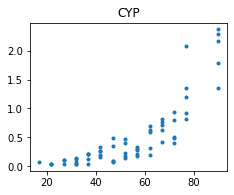

In [39]:
plt.figure(figsize=(12,6))

for i, country in enumerate(countries):
    plt.subplot(2, 3, i + 1)
    plt.title(country)

    d = data[data.area == country]
    plt.plot(d.age, d.value, '.')
    plt.plot(knots, trace[y][::5, :, i].T, color='r', alpha=.01)

    plt.ylim(0, rate.max())

In [ ]:
az.plot_forest(trace, var_names=['packed_L']);

### Exercise: Stochastic Volatility

Asset prices have time-varying volatility (variance of day over day `returns`). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. 

In [ ]:
returns = pd.read_csv('../data/SP500.csv', index_col='date')['change']
returns.head()

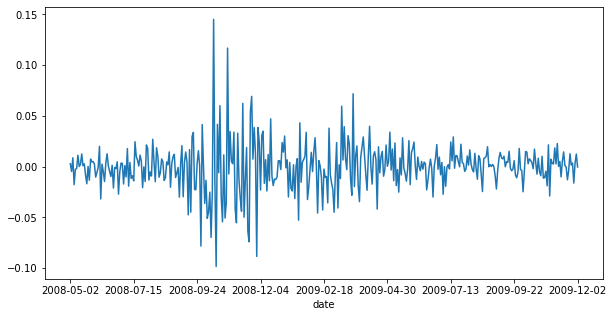

In [35]:
returns.plot(figsize=(10,5));

Construct an appropriate model for this data using a Gaussian random walk.

In [ ]:
with pm.Model() as stochastic_vol_model:
    step_size = pm.Exponential('step_size', 10)
    volatility = pm.GaussianRandomWalk(
        'volatility', 
        sigma=step_size, 
        shape=len(returns))
        
    nu = pm.Exponential('nu', 0.1)
    y = pm.StudentT('y', 
                    nu=nu, 
                    lam=np.exp(-2*volatility), 
                    observed=returns)

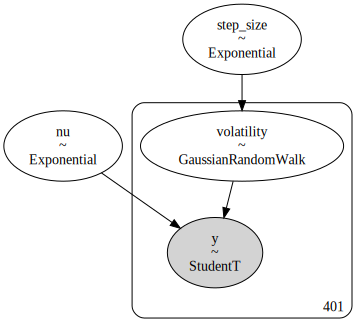

In [37]:
pm.model_to_graphviz(stochastic_vol_model)

In [63]:
with stochastic_vol_model:
    trace = pm.sample(**sampler_kwargs)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, volatility, step_size]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 201 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


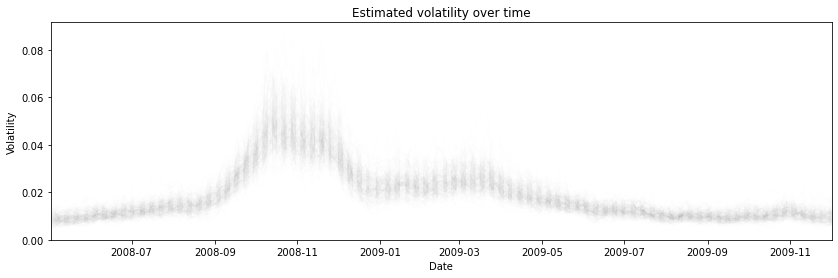

In [64]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = np.exp(trace.posterior['volatility'].to_dataframe().unstack().values[::5].T)
x_vals = np.vstack([returns.index for _ in y_vals.T]).T.astype(np.datetime64)

plt.plot(x_vals, y_vals, 'k', alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title='Estimated volatility over time', xlabel='Date', ylabel='Volatility');

In [ ]:
# Write your answer here

## Autoregressive Models

The Gaussian random walk is a special case of an autoregressive model, which is specified by:

$$y_t = \rho y_{t-1} + \epsilon_t,$$
   
where $\epsilon_t \overset{iid}{\sim} {\cal N}(0,1)$. In the case of the GRW, the parameter $\rho$ is fixed to 1; consequentially, the random increments alone drive the evolution of the state (hence the name, "random walk"). 

The form above is also a specific subclass of autoregressive model, the first-order autoregressive, or AR(1), process. This is a Markovian model because the next state is a function only of the current state. 

A yet more general form of autoregressive model is the nth-order autoregressive process, AR(n):

$$y_t = \rho_` y_{t-1} + \rho_2 y_{t-2} + \ldots + \rho_n y_{t-n} + \epsilon_t$$

Let's start with estimating an AR(1) model using PyMC3. First, let's generate some simulated data.

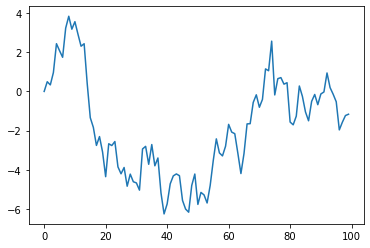

In [42]:
np.random.seed(seed=42)

T = 100
y = np.zeros(T)

for i in range(1,T):
    y[i] = 0.95 * y[i-1] + np.random.normal()

plt.plot(y);

To use a Bayesian approach, we must choose a prior for the coefficient $\rho$. We will use a Gaussian prior $\rho \sim {\cal N}(0,\tau^2)$.
This results in a posterior distribution of $\rho$ of the form:

$$
 \rho |Y^T \sim {\cal N}( \tilde{\rho}_T, \tilde{V}_T),
$$

where

$$
\begin{eqnarray}
        \tilde{\rho}_T &=& \left( \sum_{t=1}^T y_{t-1}^2 + \tau^{-2} \right)^{-1} \sum_{t=1}^T y_{t}y_{t-1} \\
        \tilde{V}_T      &=& \left( \sum_{t=1}^T y_{t-1}^2 + \tau^{-2} \right)^{-1}
\end{eqnarray}
$$

In [43]:
with pm.Model() as ar1:
    
    ρ = pm.Normal('ρ', mu=0, sigma=1.0)
    ts = pm.AR('ts', ρ, sigma=1.0, observed=y)

In [45]:
with ar1:    
    trace = pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ρ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


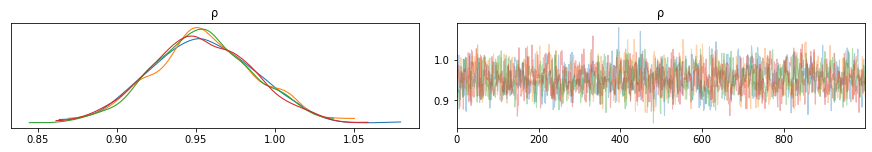

In [46]:
az.plot_trace(trace);

In [52]:
mu_p = ((y[:-1]**2).sum() + 1**-2)**-1 * np.dot(y[:-1],y[1:])
V_p =  ((y[:-1]**2).sum() + 1**-2)**-1

print('Mean: {:5.3f} (exact = {:5.3f})'.format(trace.posterior['ρ'].mean().values, mu_p))
print('Std: {:5.3f} (exact = {:5.3f})'.format(trace.posterior['ρ'].std().values, np.sqrt(V_p)))

Mean: 0.954 (exact = 0.956)
Std: 0.032 (exact = 0.032)


## Extension to AR(p)
We can instead estimate an AR(2) model using pyMC3.

$$
 y_t = \rho_1 y_{t-1} + \rho_2 y_{t-2} + \epsilon_t.
$$

The `AR` distribution infers the order of the process by size the of `rho` argmument passed to `AR`. 

In [53]:
with pm.Model() as ar2:
    ρ = pm.Normal('ρ', mu=0, sigma=1, shape=2)
    likelihood = pm.AR('likelihood', ρ, sigma=1.0, observed=y)

In [54]:
with ar2:
    trace = pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ρ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8851671755456044, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


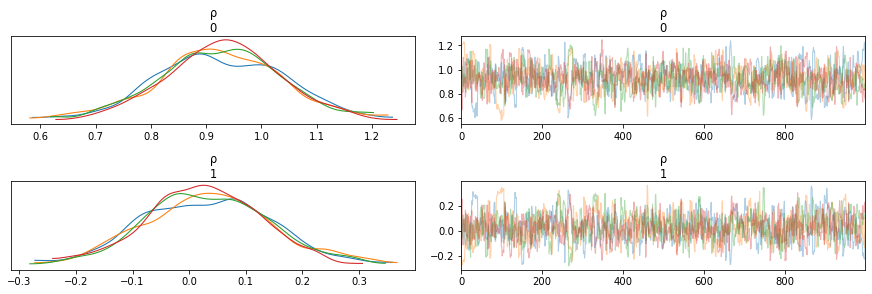

In [55]:
az.plot_trace(trace);

Notice that the estimate of $\rho_1$ is close to zero, which is understandable since the data was simulated from an AR(1) model.

## Adding a moving average: ARMA

More complex time series models are typically achieved by adding other components to the basic autoregressive model. 

A common approach is to use a **moving average**; a moving average model uses past forecast errors in a regression-like model:

$$y_{t}=c+\varepsilon_{t}+\theta_{1} \varepsilon_{t-1}+\theta_{2} \varepsilon_{t-2}+\cdots+\theta_{q} \varepsilon_{t-q}$$

Notice that the observation $y_t$ can be viewed as a weighted moving average of the past several errors. So a first-order MA process is:

$$y_{t}=c+\varepsilon_{t}+\theta_{1} \varepsilon_{t-1}$$

This is homologous to smoothing, but a moving average model is used for forecasting future values, whereas smoothing is used for estimating the trend-cycle of past values.

The motivation for the MA model is that we can explain shocks in the error process directly by fitting a model to the error terms.

> As a general rule, a low order AR process will give rise to a high order MA process and the low order MA process will give rise to a high order AR process.
> $$x_{t}=\lambda x_{t-1}+\varepsilon_{t}, \quad \lambda<1$$
> by successively lagging this equation and substituting out the lagged value of x we may rewrite this as, 
> $$x_{t}=\sum_{j=1}^{\infty} \lambda^{j} \varepsilon_{t-j} \quad \text { where } \lambda^{\infty} x_{t-\infty} \rightarrow 0$$
> So the first order AR process has been recast as an infinite order MA one. 

An AR(p) and a MA(q) process can be combined to yield an autoregressive moving average (ARMA) model as follows:

$$y_{t}=c+\phi_{1} y_{t-1}+\cdots+\phi_{p} y_{t-p}+\theta_{1} \varepsilon_{t-1}+\cdots+\theta_{q} \varepsilon_{t-q}+\varepsilon_{t}$$

Why would we want such similar components in the same model? The AR process accounts for **trends** in the stochastic process, while the MA component will soak up **unexpected events** in the time series.

A common data transformation that is applied to non-stationary time series to render them stationary is **differencing**. The differenced series is the change between consecutive observations in the original series, and can be written as

$$y_{t}^{\prime}=y_{t}-y_{t-1}$$
 
The differenced series will have only T-1 values, since it is not possible to calculate a difference for the first observation. Applying the ARMA to differenced data yields an autoregressive **integrated** moving average (ARIMA) model.

$$y_{t}^{\prime}=c+\phi_{1} y_{t-1}^{\prime}+\cdots+\phi_{p} y_{t-p}^{\prime}+\theta_{1} \varepsilon_{t-1}+\cdots+\theta_{q} \varepsilon_{t-q}+\varepsilon_{t}$$

For our purposes, we will stick with the ARMA model.

Implementing and ARMA model in PyMC3 is trickier than for the AR(n) process. It involves generating variables in a loop, which PyMC3 is not very good at, due to the underlying Theano architecture. For this, we need to add some Theano code to our model.

Let's try to fit an ARMA model to a sample dataset. We will use a common time series dataset, which is just a summary of monthly totals of international airline passengers between 1949 to 1960.

**Go ahead and run this model while you read--it takes a few minutes to fit.**

In [56]:
air_passengers = pd.read_csv('../data/AirPassengers.csv', parse_dates=[0]).set_index('Month')
air_passengers.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


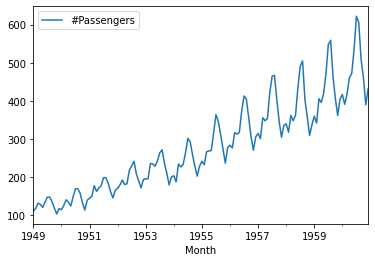

In [57]:
air_passengers.plot();

We can start, as always, by declaring our priors, which here consist of:

- observation error standard deviation: $\sigma$
- initial stsate: $\mu$
- moving average coefficient: $\theta$
- autoregression coefficient: $\rho$

For simplicity, we will model a ARMA(1, 1) process, so first order for both the moving average and autoregression.

In [70]:
with pm.Model() as arma_model:
    σ = pm.HalfNormal('σ', 5.)
    μ = pm.Normal('μ', 100., sigma=10.)
    θ = pm.Normal('θ', 0., sigma=1.)
    ρ = pm.Normal('ρ', 0., sigma=2.)

The tricky part comes with calculating the sequence of states. We cannot simply use a python `for` loop; instead, we need to write a Theano `scan` function. 

The `scan` function provides the basic functionality needed to do loops in Theano. There are three things that we need to handle: 

1. the initial value assigned to the result
2. the accumulation of results
3. the non-sequence values required by the calculation in the loop 

Unchanging variables are passed to scan as `non_sequences`, initialization occurs in `outputs_info`, and the accumulation happens automatically.

Scan returns a tuple containing our result (`err`) and a dictionary of updates, which we do not need so it is assigned to the throwaway variable `_`.

In [71]:
from theano import scan, shared

with arma_model:
    y = shared(air_passengers.values.flatten())
    
    err0 = y[0] - (μ + ρ * μ)

    def calc_next(last_y, this_y, err, μ, ρ, θ):
        nu_t = μ + ρ * last_y + θ * err
        return this_y - nu_t

    err, _ = scan(fn=calc_next,
                  sequences=dict(input=y, taps=[-1, 0]),
                  outputs_info=[err0],
                  non_sequences=[μ, ρ, θ])
    
    likelihood = pm.Normal('likelihood', 0, sigma=σ, observed=err)

In [60]:
from theano import scan

y = air_passengers.values.flatten()

with arma_model:
    err0 = (μ + ρ * μ)

    def calc_next(last_y, err, μ, ρ, θ):
        return μ + ρ * last_y + θ * err

    y_hat, _ = scan(fn=calc_next,
                    sequences=y,
                    outputs_info=[err0],
                    non_sequences=[μ, ρ, θ])

    pm.Normal('likelihood', y_hat, sigma=σ, observed=y)

Notice that, for convenience, we are modeling the residuals in our likelihood function, hence the likelihood has a zero-mean. 

In [72]:
with arma_model:
    trace = pm.sample(**sampler_kwargs,
                      target_accept=.99)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ρ, θ, μ, σ]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 586 seconds.


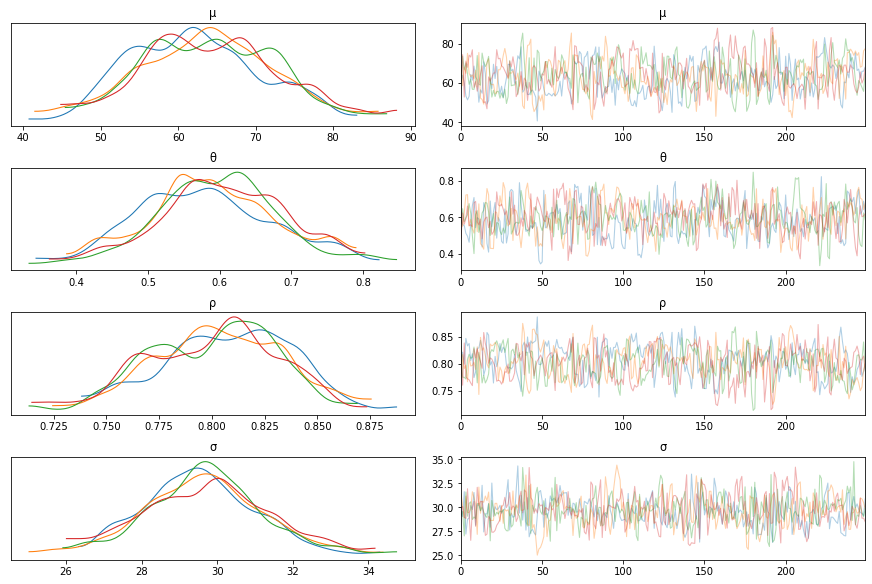

In [73]:
az.plot_trace(trace);

## Bayesian Structural Time Series Models

**Go ahead and run this model while you read--it takes a few minutes to fit.**

Another approach to time series modeling involves the use of **state-space models**, which has its origins in control engineering. For example, in navigation systems one requires continuous updating of a user's position, based on noisy data. This is analogous to what time series models try to do: make inferences about a *latent state*, based on a sequence of data. In this context, they are known as **structural time series models**. They are generally more transparent than ARIMA-type models because it is not based on autoregression or moving averages, which are not intuitive, and they are flexible and modular, making them widely-applicable to a variety of settings.

The modularity of structural time series models is their key feature. Specifically, they are comprised of an **observation equation** that specifies how the data are related to the unobserved state, and a **state dynamics equation**, which describes how the latent state evolves over time.

### Observation equation

$$y_t = \mu_t + \epsilon_t$$

The observation equation relates the observed data with the concurrent value of the unobserved state $\mu_t$. This is typially assumed to be Gaussian, but need not be:

$$\epsilon_t \sim N(0, \sigma_{\epsilon})$$

### State dynamics equation

$$\mu_{t+1} = \mu_t + \beta X_t + S_t + \eta_t$$

The state dynamics equation models the temporal dynamics of the baseline mean $\mu_t$, and is sometimes called the **unobserved trend**, since we never observe $\mu$ (though it is typically what we want to infer about). Thus, we are assuming that the state is somehow changing over time.

This regession component optionally models the influence of a set of predictor variables $X_t$, as well as a seasonality component $S_t$ on an observed time series of data $\{y_t\}$.

Analogous to the observation error, we typically assume the system errors $\eta_t$ are drawn from some random, zero-centered distribution:

$$\eta_t \sim N(0, \sigma_{\eta})$$

Additionally, we assume $\epsilon_t$ and $\eta_t$ are uncorrelated.

![state space model](images/state_space.png)

This modular structure allows the uncertainty in consituent components to be handled separately. Yet, using a Bayesian approach for inference allows all components to be estimated **simultaneously**. All estimated quantities will have posterior distributions that can be used for inference.

### Example: Snowshoe hare population dynamics

We can use structural time series modeling to create a phenomenological model of Showshoe hare (*Lepus americanus*) data. We will use a dataset consisting of 7 years of regular counts as our time series, modeling the latent population and the observation process simultaneously.

In [74]:
hare_data = pd.read_excel(
    '../data/4_Controls Hare Live trap data Kluane.xlsx', 
    sheet_name='Silver Old 10x10 overview', usecols=['date', '# Checks', '# Indiv'],
    parse_dates=True)

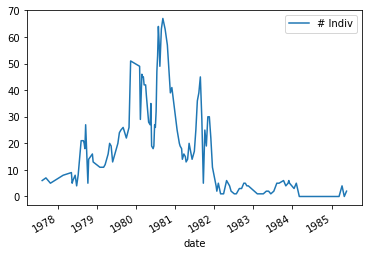

In [75]:
hare_data.plot('date', '# Indiv')

In [76]:
T = hare_data.shape[0]

In [77]:
with pm.Model() as hare_model:
    
    σ_ar = pm.HalfNormal('σ_ar', 1)
    
    ρ = pm.Normal('ρ', 1, sigma=1)
    μ = pm.AR('μ', ρ, sigma=σ_ar, shape=T)
        
    α = pm.HalfNormal('α', 1)
    like = pm.NegativeBinomial(
        'like', 
        mu=pm.math.exp(μ), 
        alpha=α, 
        observed=hare_data['# Indiv'].values)

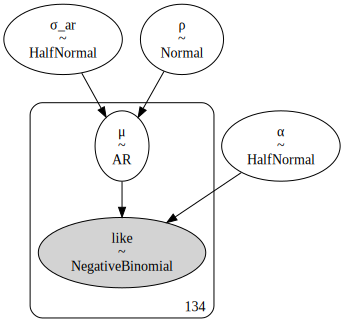

In [78]:
pm.model_to_graphviz(hare_model)

In [137]:
sampler_kwargs['return_inferencedata'] = False

In [138]:
with hare_model:
    trace = pm.sample(**sampler_kwargs, random_seed=RANDOM_SEED)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, μ, ρ, σ_ar]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 64 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


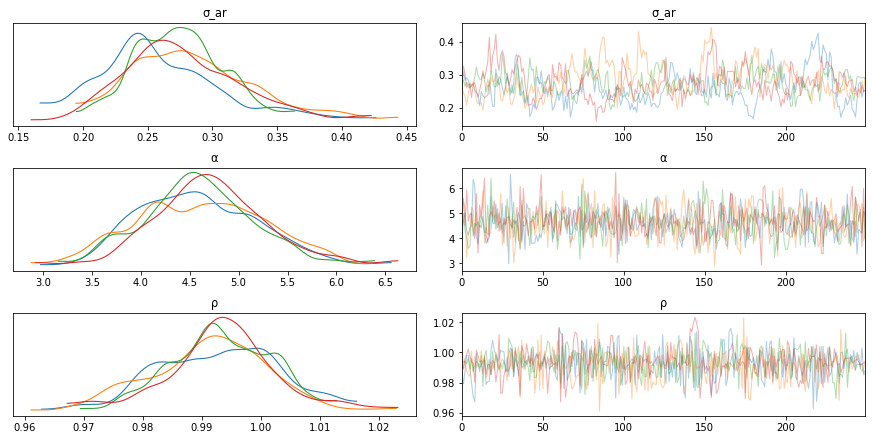

In [139]:
az.plot_trace(trace, var_names=['σ_ar', 'α', 'ρ']);

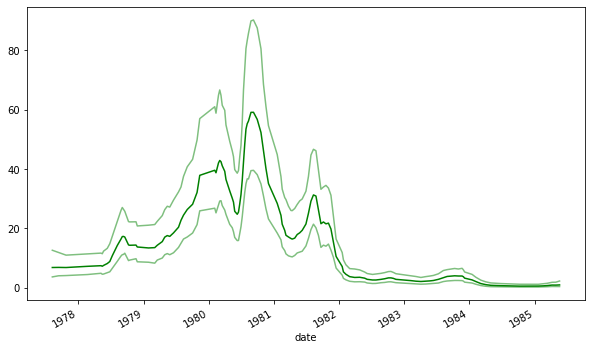

In [140]:
fig, ax = plt.subplots(figsize=(10,6))
(pd.DataFrame(np.exp(trace['μ'].mean(0)), index=hare_data.date)
      .plot(legend=False, color='Green', ax=ax))
(pd.DataFrame(np.quantile(np.exp(trace['μ']), [0.05, 0.95], axis=0).T, index=hare_data.date)
      .plot(legend=False, color='Green', ax=ax, alpha=0.5))
# hare_data.plot('date', '# Indiv', ax=ax, alpha=0.3, color='grey');

To get an idea about how our model performs, we can sample from the posterior predictive distribution, using `sample_posterior_predictive`.

In [142]:
with hare_model:
    pred_trace = pm.sample_posterior_predictive(trace,
                                                samples=500)

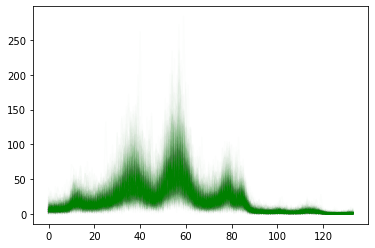

In [143]:
plt.plot(hare_data.index, pred_trace['like'].T, 
         color='g', alpha=0.01);

### Explicit seasonality model

**Go ahead and run this model while you read--it takes a few minutes to fit.**

The basic structured time series models can be problematic to fit partly because it is trying to do a lot. For example, it's obvious (particularly in the airline data) that there is a periodic effect in the data-generating model, and we are trying to make the autoregressive component account for this as well as the (linear?) trend in the mean that is independent of the seasonality.

Thus, it is wise to add an explicit seasonality component to the model, which will allow the AR(1) component to look after the trend. There are several commonly used state-component models to capture seasonality. For example:

$$\begin{split} & y_t = \tau_t +\epsilon_t, \\ & \tau_{t+d} = - \sum_{i=0}^{s-2}\tau_{t-i\times d} + \eta_{\tau, t}, \end{split}$$

where $s$ is the number of seasons and $d$ is the seasonal duration (number of time periods in each season, often set to 1). The model can be thought of as a regression on $s$ dummy variables representing $s$ seasons and $\tau_{t}$ denotes their joint contribution to the observed response $y_t$.

The mean of $\tau_{t+d}$ is such that the total seasonal effect is zero when summed over $s$ seasons

$$E(\tau_{t+d}+\sum_{i=0}^{s-2}\tau_{t-i\times d}) = 0$$

It can be helpful to display this component in matrix form:

$$\begin{split} & y_t = [1\quad 0 \quad \cdots\quad 0]\left[\begin{matrix}\tau_{t}\\\tau_{t-d}\\ \vdots\\ \tau_{t-(s-2)d}\end{matrix}\right] +\epsilon_t, \\ & \left[\begin{matrix}\tau_{t+d}\\\tau_t\\\tau_{t-d}\\ \vdots\\ \tau_{t-(s-4)d}\\ \tau_{t-(s-3)d}\end{matrix}\right] = \left[\begin{matrix} -1 & - 1 & \cdots & -1 & -1 \\ 1 & 0 & \cdots &0& 0\\ 0 & 1 & \cdots & 0 &0 \\ \vdots &\vdots &\vdots &\vdots &\vdots &\\ 0 & 0 & \cdots & 1 & 0 \\ 0 & 0 & \cdots & 0 & 0 \\ \end{matrix}\right] \left[\begin{matrix}\tau_{t}\\\tau_{t-d}\\\tau_{t-2d}\\\vdots \\ \tau_{t-(s-3)d}\\ \tau_{t-(s-2)d}\end{matrix}\right] + \left[\begin{matrix}1\\0\\0\\ \vdots\\ 0\\ 0\end{matrix}\right]\eta_{\tau, t} \end{split}
$$

Let's start with the easy part--essentially copying the AR(1) component from the previous model:

In [120]:
T = air_passengers.shape[0]
S = 12

with pm.Model() as ts_model_seasonal:
    
    # Standard deviations
    σ_η = pm.HalfNormal('σ_η', 25)
    z_η = pm.Normal('z_η', shape=S)
    η = pm.Deterministic('η', z_η * σ_η)
    
    # State dynamics
    σ_μ = pm.HalfNormal('σ_μ', 25)
    ρ = pm.Normal('ρ', 0, sigma=1)
    μ = pm.AR('μ', ρ, sigma=σ_μ, shape=T)

To implement the seasonality term, we create $S-1$ variables, and concatenate them with their negative sum, which enforces a sum-to-one constraint. Since the data are monthly, there are 12 "seasons" (and, as it happens, 12 years for a total of 144 observations). Thus, we repeat the 12 month variables 12 times:

In [121]:
n_years = int(T/S)

with ts_model_seasonal:
    
    # Seasonality
    σ_τ = pm.HalfNormal('σ_τ', 25)
    z_τ = pm.Normal('z+τ', shape=S-1)
    τ = pm.Deterministic('τ', z_τ * σ_τ)
    s = tt.concatenate(
        [[-1 * tt.sum(τ)], τ] * n_years
    ) + tt.repeat(η, S)
    
    # Likelihood
    σ_y = pm.HalfNormal('σ_y', 25)
    like = pm.Normal('like', μ + s, sigma=σ_y, 
                     observed=air_passengers.values.ravel())

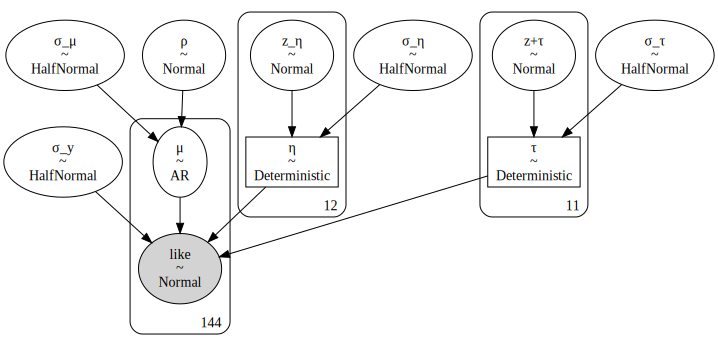

In [122]:
pm.model_to_graphviz(ts_model_seasonal)

In [127]:
with ts_model_seasonal:
    trace = pm.sample(**sampler_kwargs, target_accept=.99,
                      random_seed=RANDOM_SEED)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_y, z+τ, σ_τ, μ, ρ, σ_μ, z_η, σ_η]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 1292 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9283563660381093, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.3127319890462051, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


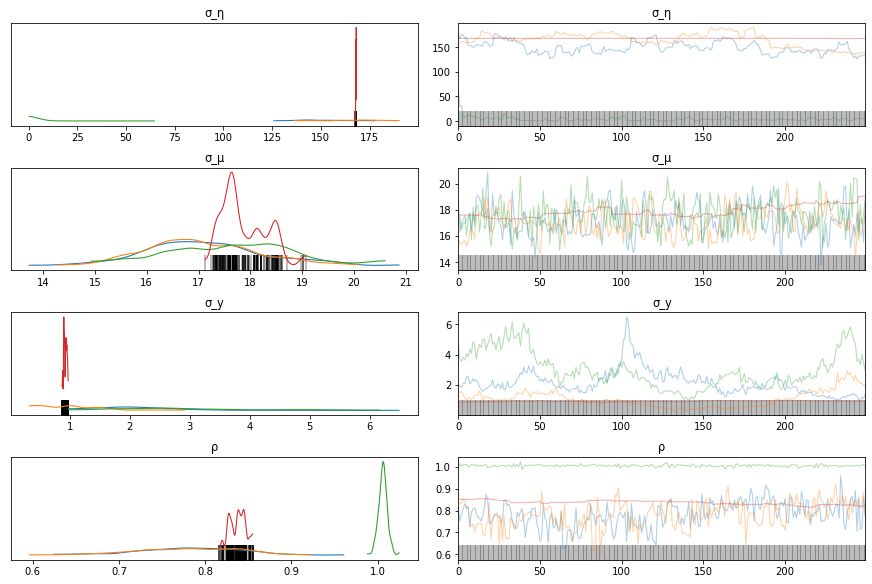

In [128]:
az.plot_trace(trace, var_names=['σ_η', 'σ_μ','σ_y', 'ρ']);

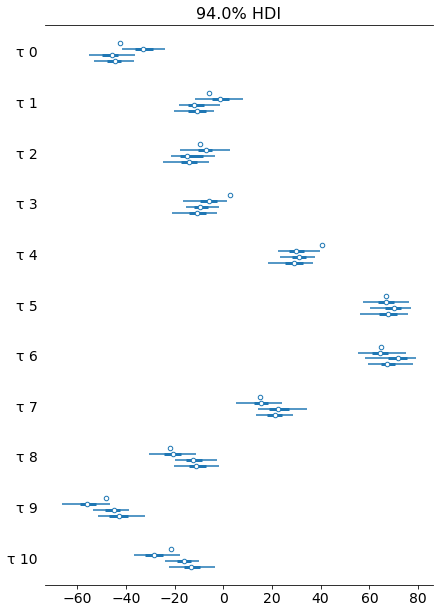

In [129]:
az.plot_forest(trace, var_names=['τ']);

In [131]:
with ts_model_seasonal:
    pred_trace = pm.sample_posterior_predictive(trace.posterior, samples=500)

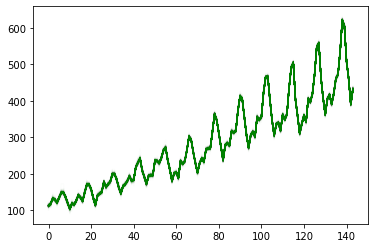

In [132]:
plt.plot(pred_trace['like'].T, color='g', alpha=0.01);

## Exercise: Electricity demand

Below is a 6-week dataset of electricity demand in the state of Victoria in Austrialia. Along with this data is an important covariate, temperature. Try modeling the time series with and without the covariate information.

In [ ]:
from electricity_demand_data import *

In [ ]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(demand_dates[:-num_forecast_steps],
        demand[:-num_forecast_steps], lw=2, label="training data")
ax.set_title("Demand")
ax.set_ylabel("Hourly demand (GW)")

ax = fig.add_subplot(2, 1, 2)

ax.plot(demand_dates[:-num_forecast_steps],
        temperature[:-num_forecast_steps], lw=2, label="training data", c=c2)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Temperature")
ax.xaxis.set_major_locator(demand_loc)
ax.xaxis.set_major_formatter(demand_fmt)
fig.suptitle("Electricity Demand in Victoria, Australia (2014)",
             fontsize=15)
fig.autofmt_xdate()

In [ ]:
# Write your answer here

---
# References

Lyle Broemeling [Bayesian Analysis of Time Series](https://www.amazon.com/Bayesian-Analysis-Time-Lyle-Broemeling/dp/1138591521)

[Quantopian Lecture Series](https://www.quantopian.com/lectures)

Tingting Yu,  [Structural Time Series Models](http://oliviayu.github.io/post/2019-03-21-bsts/)